In [6]:
%load_ext autoreload
%autoreload 2

import builtins
import IPython.lib.deepreload
builtins.reload = IPython.lib.deepreload.reload # type: ignore

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import math
from typing import List

import numpy as np
import matplotlib.pyplot as plt

from swcgeom.analysis import draw, BranchFeatures
from swcgeom import Tree, tree_utils
from swcgeom.core import swc_utils

In [8]:
swc1 = "data/101711-10_4p5-of-16_initial.CNG.swc"
swc2 = "data/101711-11_16-of-16_initial.CNG.swc"
swc3 = "data/1059283677_15257_2226-X16029-Y23953.swc"

# create a tree
tree1 = Tree.from_swc(swc1)
tree2 = Tree.from_swc(swc2)
tree3 = Tree.from_eswc(swc3)

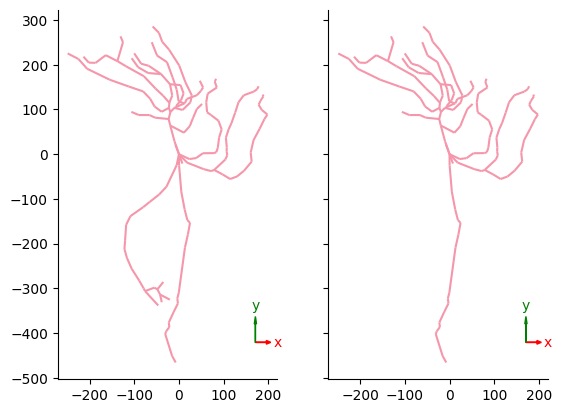

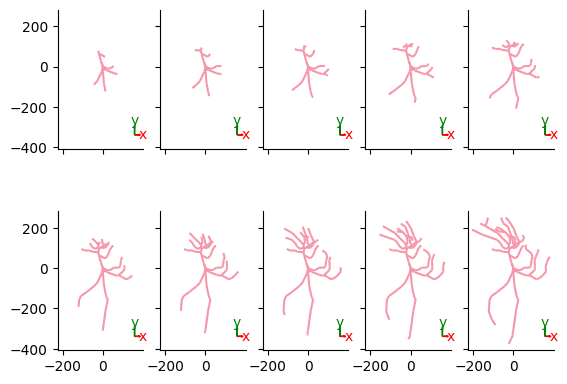

In [9]:
def cut_3(n: Tree.Node, _) -> tuple[None, bool]:
    return None, n.id == 3

tree_cut3 = tree_utils.cut_tree(tree1, leave=cut_3)

fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True, sharey=True)
draw(tree1, ax=ax0)
draw(tree_cut3, ax=ax1)

def cut_level(max_level: int):
    def cut(n: Tree.Node, parent_level: int | None) -> tuple[int, bool]:
        level = 0 if parent_level is None else parent_level + 1
        return (level, level > max_level)
    return cut

fig, axes = plt.subplots(2, 5, sharex=True, sharey=True)
axes = axes.flatten()
for i in range(10):
    tree_cut100 = tree_utils.cut_tree(tree1, enter=cut_level(i+3))
    draw(tree_cut100, ax=axes[i])

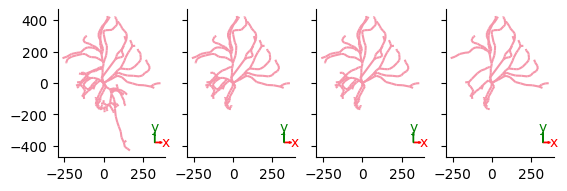

In [10]:
def cut_by_angle(tree: Tree, keep_angle: float = 10):
    branches = tree.get_branches()
    angle = BranchFeatures.calc_angle(branches)
    cutted = np.logical_or(
        np.logical_and(
            angle > (90 - keep_angle) / 180 * math.pi,
            angle < (90 + keep_angle) / 180 * math.pi
        ),
        np.logical_and(
            angle > (270 - keep_angle) / 180 * math.pi,
            angle < (270 + keep_angle) / 180 * math.pi
        ),
    )

    removals = []

    def collect_cut(n: Tree.Node, children: List[int]) -> int:
        if len(children) <= 1:
            return n.id

        br_id = -1
        for i, br in enumerate(branches):
            if br[-1].id == n.id:
                br_id = i

        for child in children:
            for i, br in enumerate(branches):
                if br[0].id == n.id and br[1].id == child and cutted[br_id, i]:
                    removals.append(child)

        return n.id


    tree.traverse(leave=collect_cut)
    return tree_utils.to_subtree(tree, removals)

fig, axes = plt.subplots(1, 4, sharex=True, sharey=True)
draw(tree2, ax=axes[0])

for i, keep_angle in enumerate([10, 15, 20]):
    new_tree = cut_by_angle(tree2, keep_angle=keep_angle)
    draw(new_tree, ax=axes[i+1])